# PROYECTO DE REDES SOCIALES-GRUPO19

In [ ]:
#importar librerias necesarias

#! pip install python-louvain
import pandas as pd
import re
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain
from networkx.algorithms.community import k_clique_communities
from networkx.algorithms import community
import seaborn as sns
from scipy.stats import kruskal
from scipy.stats import f_oneway, chi2_contingency

## FASE1
Para la fase inicial del análisis en Gephi, donde el objetivo es identificar actores relevantes de la red usando medidas de centralidad y transitividad se toma la decisión de no incluir ningún atributo, en los siguientes pasos del proyecto se hará la selección de atributos relevantes para la red de inversionistas.
Adicionalmente el atributo de identidad "Id" del archivo nodos y para el archivo de arcos "Source" y "Target" se estandarizara para facilitar la conexion con los arcos.

In [3]:

# Definir la función de limpieza de texto
def clean_text(text):
    if isinstance(text, str):
        text = text.upper()  # Convertir a mayúsculas
        text = re.sub(r"[^A-Z0-9, ]", "", text)  # Eliminar caracteres especiales excepto comas y espacios
        text = re.sub(r"\s+", " ", text).strip()  # Eliminar espacios extra
    return text

# Cargando el archivo de Excel
archivo_path_nodos = "Nodos-original.xlsx"
archivo_path_arcos = "Arcos-original.xlsx"
df_nodos = pd.read_excel(archivo_path_nodos)
df_arcos = pd.read_excel(archivo_path_arcos)

# Aplicar la función clean_text al campo 'Id' de nodos y campos "Source y Target" de Arcos
df_nodos["Id"] = df_nodos["Id"].astype(str).apply(clean_text)
df_nodos.rename(columns={"Id": "Label"}, inplace=True) # Se cambia el nombre del id a label para que lo lea gephi
df_nodos2=df_nodos['Label']
df_arcos["Source"] = df_arcos["Source"].astype(str).apply(clean_text)
df_arcos["Target"] = df_arcos["Target"].astype(str).apply(clean_text)
df_arcos["Type"] ='directed' # Directed porque es una relación de inversión

#Descargar archivo para etapa1
df_nodos2.to_csv("nodos.csv",index=False)
df_arcos.to_csv("arcos.csv",index=False)

## FASE2
En esta fase ustedes actuarán bajo el rol de un fondo inversionista que busca comprender el comportamiento inversionista de diferentes organizaciones para mejorar la forma en la cual dispone de sus recursos en diferentes inversiones. En particular, el fondo quiere comprender cuáles son los atributos individuales de las organizaciones que son relevantes en la formación de relaciones de inversión. Para esto, se espera que implementen algoritmos de detección de comunidades y desarrollen un análisis descriptivo de los atributos de los nodos dentro y entre comunidades.Se debe entregar un notebook donde:
1. Se realice un análisis de los atributos en común entre los nodos de las comunidades. Para esto, se espera que se utilicen los algoritmos de detección de comunidades que se consideren pertinentes.
2. Se concluya al respecto para cada algoritmo seleccionado.
3. Se presente una recomendación en el contexto del problema desde el rol de una organización que busca financiación.


Es clave seleccionar atributos que permitan detectar nodos influyentes y estructuras de conexión, por lo que se propone en una primera fase seleccionar los siguientes campos:Headquarters Location, Number of Investments, Number of Lead Investments,Number of Diversity Investments, Number of Exits, Number of Lead Investors,Number of Investors, Number of Funding Rounds, Total Funding Amount Currency (in USD)

Los Posibles atributos seran homologados a:

| Nombre original                                 | Homologación en español                | Explicación de la selección                                                                                                   |
|------------------------------------------------|----------------------------------------|--------------------------------------------------------------------------------------------------------------------------------|
| Headquarters Location                          | Ubicación de la empresa               | Permitira analizar si la ubicación geográfica influye en la relevancia de los actores de la red.                                |
| Number of Investments                          | Número de inversiones                 | Este atributos ayudarán a analizar el # de inversiones realizadas por la empresas o inversionistas.                             |
| Number of Lead Investments                     | Número de inversiones como líder      | Permitira identificar empresas que lideran muchas inversiones podrían tener un papel clave en la red.                           |
| Number of Diversity Investments                | Número de inversiones diversificadas  | Permite identificar empresas que diversifican que podrian tener conexiones más amplias en la red.                               |
| Number of Exits                                | Número de salidas a bolsa             | Permite identificar empresas con múltiples exits que podrian indicar experiencia en mercados y atraer más inversionistas.       |
| Number of Lead Investors                       | Número de inversionistas principales  | Permite identificar la cantidad de inversionistas principales dentro de una empresa, lo que podría indicar relevancia.          |
| Number of Investors                            | Número de inversionistas              | Permite identificar la cantidad de inversionistas en una empresa, seria útil para medir su atractivo en el ecosistema.          |
| Number of Funding Rounds                       | Número de rondas de financiación      | Permite identificar la cantidad de rondas de financiación, lo que podria indicar estabilidad y crecimiento.                     |
| Total Funding Amount Currency (in USD)         | Monto total de financiación (USD)     | Permite identificar aquellas empresas con más financiamiento podrian tener más relevancia en la red.                            |
| Industries                                     | Industria                             | Permite identificar la industria a la cual pertenece la empresa o ionversionista, para analizar si esto es un factor influyente |


In [4]:
# Diccionario con los nombres nuevos
nombres_columnas = {
    "Headquarters Location": "Ubicación de la empresa",
    "Number of Investments": "Número de inversiones",
    "Number of Lead Investments": "Número de inversiones como líder",
    "Number of Diversity Investments": "Número de inversiones diversificadas",
    "Number of Exits": "Número de salidas a bolsa",
    "Number of Lead Investors": "Número de inversionistas principales",
    "Number of Investors": "Número de inversionistas",
    "Number of Funding Rounds": "Número de rondas de financiación",
    "Total Funding Amount Currency (in USD)": "Monto total de financiación (USD)",
    "Industries": "Industria"
}

# Seleccionar las columnas candidatas a atributos (excluyendo campos irrelevantes)
columnas_candidatas = [
    "Label","Industries","Headquarters Location", "Number of Investments", "Number of Lead Investments",
    "Number of Diversity Investments", "Number of Exits", "Number of Lead Investors",
    "Number of Investors", "Number of Funding Rounds", "Total Funding Amount Currency (in USD)"
]
#Seleccionando columnas 
df_nodos2=df_nodos[columnas_candidatas]

#Homologacion de campos en el DataFrame
df_nodos2.rename(columns=nombres_columnas, inplace=True)

# Conteo de valores nulos por columna candidata
nulos = (df_nodos2.isnull().sum()/df_nodos2.shape[0])*100

# Mostrar el conteo de valores nulos
print("Porcentaje de valores nulos por columna candidata:")
print(nulos)

Porcentaje de valores nulos por columna candidata:
Label                                    0.000000
Industria                                1.990050
Ubicación de la empresa                  1.175938
Número de inversiones                   32.428765
Número de inversiones como líder        39.032112
Número de inversiones diversificadas    52.103121
Número de salidas a bolsa               45.409317
Número de inversionistas principales    50.791497
Número de inversionistas                45.952058
Número de rondas de financiación        42.379014
Monto total de financiación (USD)       45.499774
dtype: float64


C:\Users\User\AppData\Local\Temp\ipykernel_6212\1733364484.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nodos2.rename(columns=nombres_columnas, inplace=True)


**Observando los porcentajes de nulos:**

Teniendo en cuenta la cantidad de nulos en los atributos candidatos,se toma las siguientes decisiones:
* Industria (1.99% nulos): Muy relevante para segmentar comunidades según el sector económico. La baja cantidad de nulos se puede imputar consultando la información en la web, evitando así generar ruido.
* Ubicación de la empresa (1.18% nulos): Ayuda a entender relaciones geográficas y tendencias regionales de inversión. Se puede imputar consultando la información en la web, evitando así generar ruido.
* Número de salidas a bolsa : Aporta valor estratégico al análisis, ya que las organizaciones con salidas a bolsa pueden formar comunidades de alto impacto, podrian ayudar a identificar líderes del mercado o influenciadores en la red.Se decide imputar con la mediana por industria para mantener consistencia sin afectar el análisis.
* Monto total de financiación (USD) (45.5% nulos): Muy relevante para identificar comunidades según el poder de financiación. La alta cantidad de nulos sugiere:Imputar con mediana por estado para no sesgar el análisis.
* Número de inversiones (32.43% nulos): Es un atributo crítico para analizar la actividad inversionista, pero la cantidad de nulos es considerable. Se decide eliminar registros con nulos.
* Número de inversiones como líder (39.03% nulos): Es útil para detectar inversores influyentes. Se decide eliminar registros con nulos.
* Número de inversiones diversificadas (52.1% nulos) y Número de inversionistas principales (50.8% nulos): Dado el alto porcentaje de nulos, se decide no considerar estos campos para la fase 2, ya que podrían introducir demasiado ruido.


In [5]:
#Quitando de mi df los campos Número de inversiones diversificadas y Número de inversionistas principales
df_nodos3 = df_nodos2.drop(columns=['Número de inversiones diversificadas', 'Número de inversionistas principales'])

#Eliminando registros nulos en  Número de inversiones,Número de inversiones como líder
df_nodos4 = df_nodos3.dropna(subset=['Número de inversiones', 'Número de inversiones como líder','Número de inversionistas'])

#volviendo a evaluar cantidad de nulos en el df
nulos2 = (df_nodos4.isnull().sum()/df_nodos4.shape[0])*100

# Mostrar el conteo de valores nulos
print("Porcentaje de valores nulos por columna candidata:")
print(nulos2)

print('El archivo tenía un total de {} registros y después de eliminar registros nulos de ciertos campos quedó con {} registros.'.format(df_nodos3.shape[0], df_nodos4.shape[0]))

Porcentaje de valores nulos por columna candidata:
Label                                 0.000000
Industria                             1.007557
Ubicación de la empresa               0.251889
Número de inversiones                 0.000000
Número de inversiones como líder      0.000000
Número de salidas a bolsa            26.448363
Número de inversionistas              0.000000
Número de rondas de financiación      0.000000
Monto total de financiación (USD)    13.350126
dtype: float64
El archivo tenía un total de 2211 registros y después de eliminar registros nulos de ciertos campos quedó con 397 registros.


**Realizando Imputaciones Categoricas** 

In [6]:
#Miremos las industrias que hay?
print(df_nodos4['Industria'].unique())
#miremos cuales registros no tienen industria??
df_nodos4[df_nodos4['Industria'].isnull()]

#Segun la investigacion en la Web se encontro que:
## Orange es una empresa que provee servicios a nivel global de telefonía móvil, telefonía fija, Internet, Internet móvil, y servicios de televisión por IP. por lo que se puede situar en : Telecommunications o Information Technology
##  Las operaciones de OMAN TECHNOLOGY FUND se centran en definir las ideas futuristas en el sector tecnológico, y entre los emprendedores que tienen ideas/proyectos de tecnología e innovación técnica de alto potencial,por lo que podria ser: Consulting, Information Services, Information Technology
##  ALIVE combate la desigualdad económica invirtiendo en empresas innovadoras de alto crecimiento que ofrecen a comunidades de bajos ingresos, por lo que podria ser: 'Investment, Financial Services, Impact Investing'.
## ACCESS VENTURES Nuestra misión es revolucionar el panorama de la inversión global a través de un enfoque de financiación combinada y una mentalidad de un solo bolsillo: 'Investment, Financial Services, Impact Investing'.

#Adiccionando información
df_nodos4.loc[df_nodos4['Label'] == 'ORANGE', 'Industria'] = 'Telecommunications,Information Technology'
df_nodos4.loc[df_nodos4['Label'] == 'OMAN TECHNOLOGY FUND', 'Industria'] = 'Consulting, Information Services, Information Technology'
df_nodos4.loc[df_nodos4['Label'] == 'ALIVE VENTURES	', 'Industria'] = 'Investment, Financial Services, Impact Investing'
df_nodos4.loc[df_nodos4['Label'] == 'ACCESS VENTURES', 'Industria'] = 'Investment, Financial Services, Impact Investing'

['Advertising, Internet, Online Games, Online Portals, Social Media Marketing'
 'Blogging Platforms, Messaging, SMS, Social Media'
 'Commercial Real Estate, Coworking, Property Development, Real Estate'
 'Banking, Finance, Financial Services, FinTech, Payments'
 'Finance, Financial Services, Venture Capital'
 'Crowdfunding, Finance, FinTech, Funding Platform'
 'Communications Infrastructure, Information Technology, Mobile, Telecommunications'
 'Blockchain, Cryptocurrency, Financial Services, FinTech'
 'Food Delivery, Mobile Apps, Reservations, Restaurants'
 'Analytics, Business Intelligence, Computer, Finance, Software'
 'Crowdfunding, Finance, Financial Services, Funding Platform'
 'Delivery, Food and Beverage, Food Delivery'
 'Enterprise Software, Messaging, Mobile Apps, SMS, Software'
 'E-Commerce, Mobile Apps, Shopping, Social'
 'Audio, Consumer Electronics, Hardware, Music, Software, Wireless'
 'Biotechnology, Health Care, Life Science, Manufacturing, Marketing, Medical, Pharmaceu

In [7]:
#Miremos la cantidad de Ubicaciónes que hay?
print(df_nodos4['Ubicación de la empresa'].unique())
#miremos cuales registros no tienen Ubicación??
df_nodos4[df_nodos4['Ubicación de la empresa'].isnull()]
#Segun la investigacion la empresa UNIVERSAL MATERIALS INCUBATOR esta ubicada en 'Tokyo, Tokyo, Japan'

#Adiccionando información
df_nodos4.loc[df_nodos4['Label'] == 'UNIVERSAL MATERIALS INCUBATOR', 'Ubicación de la empresa'] = 'Tokyo, Tokyo, Japan'

['Shenzhen, Guangdong, China' 'San Francisco, California, United States'
 'New York, New York, United States' 'Jakarta, Jakarta Raya, Indonesia'
 'Boulder, Colorado, United States'
 'West Hollywood, California, United States'
 "Seoul, Seoul-t'ukpyolsi, South Korea" 'Gurgaon, Haryana, India'
 'Walldorf, Baden-Wurttemberg, Germany' 'Bangalore, Karnataka, India'
 'Shanghai, Shanghai, China' 'Santa Barbara, California, United States'
 'Paris, Ile-de-France, France' 'Singapore, Central Region, Singapore'
 'Ottawa, Ontario, Canada' 'Moscow, Moscow City, Russian Federation'
 'Mumbai, Maharashtra, India' 'Tokyo, Tokyo, Japan'
 'Menlo Park, California, United States'
 'San Jose, California, United States'
 'Lincolnshire, Illinois, United States' 'Tallinn, Harjumaa, Estonia'
 'Jersey City, New Jersey, United States'
 'Vancouver, British Columbia, Canada' 'Chicago, Illinois, United States'
 'Ar Riyadh, Ar Riyad, Saudi Arabia' "Taipei, T'ai-pei, Taiwan"
 'Aliso Viejo, California, United States' 'B

**Transformando los campos categoricos**

se hace una normalización de Texto(convertir a mayúsculas y elimina espacios innecesarios para uniformidad).Adicionalmente se hara:
* Se asumira para efectos del ejercicio, que la primera caracteristica que aparece en la industria es la principal, por lo cual esta es la que se tomara.
* Para la ubicacion se dejara el estado, la cual es la seguna carateristica de la lista.

In [8]:
# Función para limpiar y normalizar el texto
def clean_text(text):
    if pd.isna(text):
        return ""  # Retorna un string vacío si el valor es NaN
    text = text.upper()  # Convertir a mayúsculas
    text = re.sub(r"[^A-Z0-9, ]", "", text)  # Eliminar caracteres especiales excepto comas y espacios
    text = re.sub(r"\s+", " ", text).strip()  # Eliminar espacios extra
    return text

# Aplicar la función de limpieza al campo de Industria
df_nodos4['Industria'] = df_nodos4['Industria'].apply(clean_text)

# funcion para Tomar la primera industria
def extract_industria(industria):
    if industria:
        return industria.split(',')[0]  # El estado es el 2 elemento antes de la coma
    return ""

# Aplicar la función para extraer solo la 1 industria
df_nodos4['Industria'] = df_nodos4['Industria'].apply(extract_industria)
df_nodos4.head()

C:\Users\User\AppData\Local\Temp\ipykernel_6212\1913434183.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nodos4['Industria'] = df_nodos4['Industria'].apply(clean_text)
C:\Users\User\AppData\Local\Temp\ipykernel_6212\1913434183.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nodos4['Industria'] = df_nodos4['Industria'].apply(extract_industria)


,Label,Industria,Ubicación de la empresa,Número de inversiones,Número de inversiones como líder,Número de salidas a bolsa,Número de inversionistas,Número de rondas de financiación,Monto total de financiación (USD)
0,TENCENT,ADVERTISING,"Shenzhen, Guangdong, China",693.000,375.0,125.0,4.0,6.0,1.257677e+10
2,TWITTER,BLOGGING PLATFORMS,"San Francisco, California, United States",10.000,2.0,3.0,37.0,19.0,4.430192e+09
4,WEWORK,COMMERCIAL REAL ESTATE,"New York, New York, United States",9.000,6.0,2.0,24.0,21.0,2.159578e+10
6,XENDIT,BANKING,"Jakarta, Jakarta Raya, Indonesia",5.000,3.0,NaN,9.0,6.0,2.147200e+08
7,TECHSTARS,FINANCE,"Boulder, Colorado, United States",3.569,491.0,363.0,11.0,6.0,1.088000e+08


In [9]:
# Función para extraer solo el estado
def extract_city(location):
    if location:
        return location.split(',')[1]  # El estado es el 2 elemento antes de la coma
    return ""

# Aplicar la función de limpieza al campo de Ubicación
df_nodos4['Ubicación Normalizada'] = df_nodos4['Ubicación de la empresa'].apply(clean_text)

# Aplicar la función para extraer solo el estado
df_nodos4['Estado'] = df_nodos4['Ubicación Normalizada'].apply(extract_city)

#Mostrar las primeras filas del DataFrame resultante
df_nodos4.head()

C:\Users\User\AppData\Local\Temp\ipykernel_6212\403267596.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nodos4['Ubicación Normalizada'] = df_nodos4['Ubicación de la empresa'].apply(clean_text)
C:\Users\User\AppData\Local\Temp\ipykernel_6212\403267596.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nodos4['Estado'] = df_nodos4['Ubicación Normalizada'].apply(extract_city)


,Label,Industria,Ubicación de la empresa,Número de inversiones,Número de inversiones como líder,Número de salidas a bolsa,Número de inversionistas,Número de rondas de financiación,Monto total de financiación (USD),Ubicación Normalizada,Estado
0,TENCENT,ADVERTISING,"Shenzhen, Guangdong, China",693.000,375.0,125.0,4.0,6.0,1.257677e+10,"SHENZHEN, GUANGDONG, CHINA",GUANGDONG
2,TWITTER,BLOGGING PLATFORMS,"San Francisco, California, United States",10.000,2.0,3.0,37.0,19.0,4.430192e+09,"SAN FRANCISCO, CALIFORNIA, UNITED STATES",CALIFORNIA
4,WEWORK,COMMERCIAL REAL ESTATE,"New York, New York, United States",9.000,6.0,2.0,24.0,21.0,2.159578e+10,"NEW YORK, NEW YORK, UNITED STATES",NEW YORK
6,XENDIT,BANKING,"Jakarta, Jakarta Raya, Indonesia",5.000,3.0,NaN,9.0,6.0,2.147200e+08,"JAKARTA, JAKARTA RAYA, INDONESIA",JAKARTA RAYA
7,TECHSTARS,FINANCE,"Boulder, Colorado, United States",3.569,491.0,363.0,11.0,6.0,1.088000e+08,"BOULDER, COLORADO, UNITED STATES",COLORADO


**Realizando Imputaciones Numericas** 

In [10]:
#Para imputar el campo 'Monto total de financiación (USD)' usando la mediana del estado para no sesgar la informacion se hara :
#1. Asegurarnos de que el campo de Monto total de financiación se ha numérico
df_nodos4['Monto total de financiación (USD)'] = pd.to_numeric(df_nodos4['Monto total de financiación (USD)'], errors='coerce')

# 2. Calcular la mediana por Estado
mediana_por_estado = df_nodos4.groupby('Estado')['Monto total de financiación (USD)'].median()

# 3. Imputar los valores nulos con la mediana del Estado correspondiente
df_nodos4['Monto total de financiación (USD)'] = df_nodos4.apply(
    lambda row: mediana_por_estado[row['Estado']] if pd.isna(row['Monto total de financiación (USD)']) else row['Monto total de financiación (USD)'],
    axis=1
)

#Validando que no haya quedado nulos
print(df_nodos4['Monto total de financiación (USD)'].isnull().sum())

#eliminar los 3 registros que quedan vacios porque no se pudo encontrar una mediana por sector en estos
df_nodos5 = df_nodos4.dropna(subset=['Monto total de financiación (USD)'])

3


C:\Users\User\AppData\Local\Temp\ipykernel_6212\2265672462.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nodos4['Monto total de financiación (USD)'] = pd.to_numeric(df_nodos4['Monto total de financiación (USD)'], errors='coerce')
C:\Users\User\AppData\Local\Temp\ipykernel_6212\2265672462.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nodos4['Monto total de financiación (USD)'] = df_nodos4.apply(


In [11]:
#Para imputar el campo  'Número de salidas a bolsa' utilizamos la mediana por industria
# 1.  Asegurarnos de que el campo Número de salidas a bolsa se ha numérico
df_nodos5['Número de salidas a bolsa'] = pd.to_numeric(df_nodos5['Número de salidas a bolsa'], errors='coerce')

# 2. Calcular la mediana por industria
mediana_por_industria = df_nodos5.groupby('Industria')['Número de salidas a bolsa'].median()

# 3. Imputar los valores nulos usando esta mediana, para reflejar mejor la distribución real sin sesgar el análisis.
df_nodos5['Número de salidas a bolsa'] = df_nodos5.apply(
    lambda row: mediana_por_industria[row['Industria']] if pd.isna(row['Número de salidas a bolsa']) else row['Número de salidas a bolsa'],
    axis=1
)
    
# 4. Validando que no haya quedado nulos
print(df_nodos5['Número de salidas a bolsa'].isnull().sum())

#eliminar los 17 registros que quedan vacios porque no se pudo encontrar una mediana por industria en estos, ya que se puede decir que se tenia una insuficiencia de datos en algunas industrias: No se encontraron suficientes observaciones en ciertos sectores para calcular una mediana representativa.
df_nodos6 = df_nodos5.dropna(subset=['Número de salidas a bolsa'])

# Mostrar el conteo de valores nulos finales
nulos3 = (df_nodos6.isnull().sum()/df_nodos6.shape[0])*100
print("Porcentaje de valores nulos por columna candidata:")
print(nulos3)

df_nodos6= df_nodos6.drop(columns=['Ubicación de la empresa', 'Ubicación Normalizada'])

print("Dimension final de la tabla de nodos:")
print(df_nodos6.shape)

17
Porcentaje de valores nulos por columna candidata:
Label                                0.0
Industria                            0.0
Ubicación de la empresa              0.0
Número de inversiones                0.0
Número de inversiones como líder     0.0
Número de salidas a bolsa            0.0
Número de inversionistas             0.0
Número de rondas de financiación     0.0
Monto total de financiación (USD)    0.0
Ubicación Normalizada                0.0
Estado                               0.0
dtype: float64
Dimension final de la tabla de nodos:
(377, 9)


C:\Users\User\AppData\Local\Temp\ipykernel_6212\530462693.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nodos5['Número de salidas a bolsa'] = pd.to_numeric(df_nodos5['Número de salidas a bolsa'], errors='coerce')
C:\Users\User\AppData\Local\Temp\ipykernel_6212\530462693.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nodos5['Número de salidas a bolsa'] = df_nodos5.apply(


### Análisis de los atributos en común entre los nodos de las comunidades.
Vamos abordar este analisis en varios pasos:

* 1. Construcción del grafo: Crear un grafo dirigido usando NetworkX.
* 2. Aplicación de algoritmos de detección de comunidades: Probaremos varios métodos y seguidamente se realiza un análisis descriptivo de comunidades(Análisis descriptivo de atributos y Análisis de atributos gráficos).

  * 2.1 Método de Optimización (Louvain) usando community_louvain.
  * 2.2 Método de Overlapping Communities utilizando k_clique_communities.
  * 2.3 Método Dinámico (Infomap) para identificar comunidades dinámicas.
* 3. Seleccion de algoritmo, Visualización de comunidades y conclusiones: Graficar el grafo con las comunidades identificadas y explorar los atributos en común.

### Paso1: Crear el grafo

Número de nodos: 2165
Número de aristas: 4187
Nodos: ['TENCENT', 'TWITTER', 'WEWORK', 'XENDIT', 'TECHSTARS'] ...
Aristas: [('TENCENT', 'UBISOFT'), ('TENCENT', 'PHONEPE'), ('TENCENT', 'LYFT'), ('TENCENT', 'NIO'), ('TENCENT', 'OMNIPRESENT')] ...


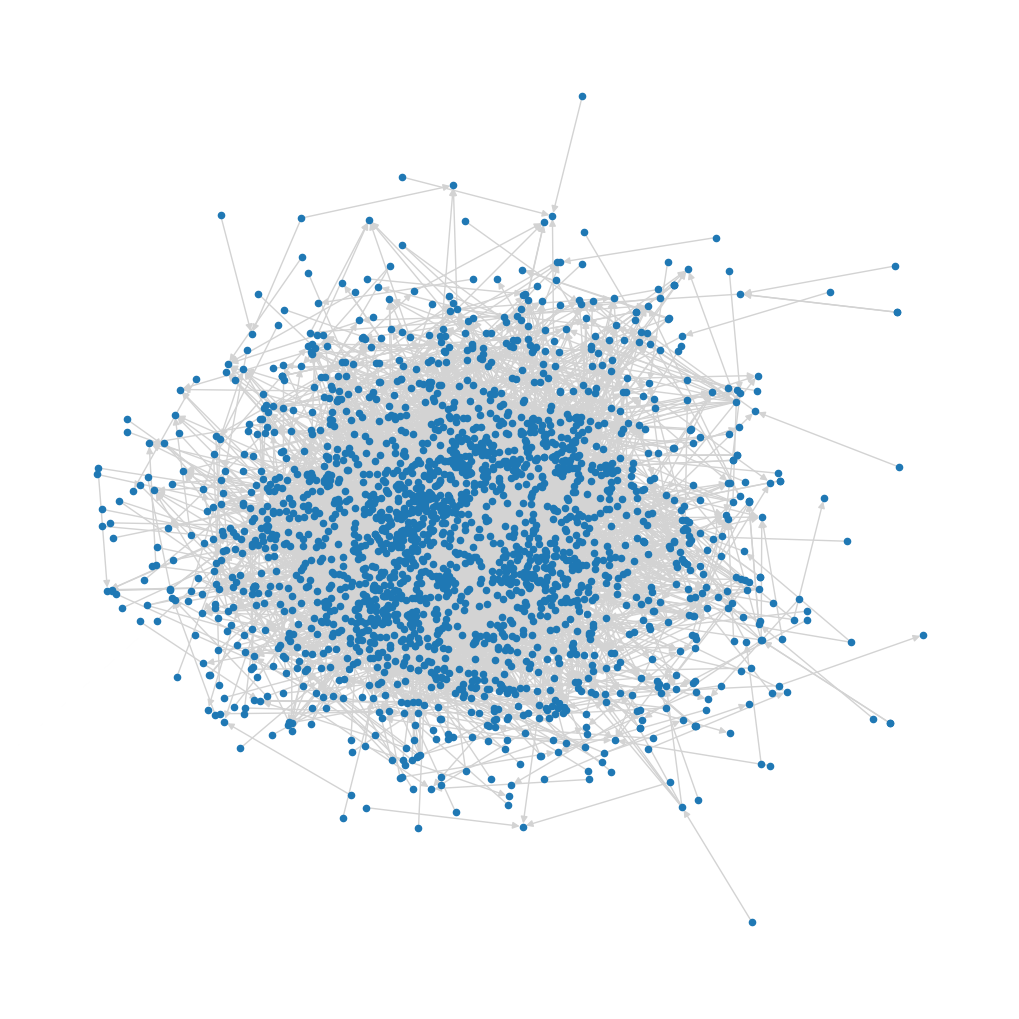

In [ ]:
# Crear el grafo dirigido
G = nx.DiGraph()

# Añadir nodos con sus atributos
for i, row in df_nodos6.iterrows():
    G.add_node(row['Label'], 
               industria=row['Industria'],
               num_inversiones=row['Número de inversiones'],
               num_lider=row['Número de inversiones como líder'],
               num_salida_bolsa=row['Número de salidas a bolsa'],
               num_inversionistas=row['Número de inversionistas'],
               num_rondas=row['Número de rondas de financiación'],
               monto_financiacion=row['Monto total de financiación (USD)'],
               estado=row['Estado'])

# Añadir arcos (relaciones de inversión)
for i, row in df_arcos.iterrows():
    G.add_edge(row['Source'], row['Target'], tipo=row['Type'])

# Información del grafo
print(f"Número de nodos: {G.number_of_nodes()}")
print(f"Número de aristas: {G.number_of_edges()}")
print(f"Nodos: {list(G.nodes())[:5]} ...")  # Muestra solo los primeros 5
print(f"Aristas: {list(G.edges())[:5]} ...")  # Muestra solo las primeras 5

# Crear el lienzo para la red
fig=plt.figure(figsize=(10,10))
# Generar el gráfico
nx.draw_kamada_kawai(G,node_size=20, edge_color='lightgray')
# Mostrar la gráfica           
plt.show()

### Paso2: Deteccion de comunidades
Probamos con varios métodos para identificar comunidades.

##### 2.1 Método de Optimización: Louvain

Número de comunidades detectadas usando (Louvain): 38


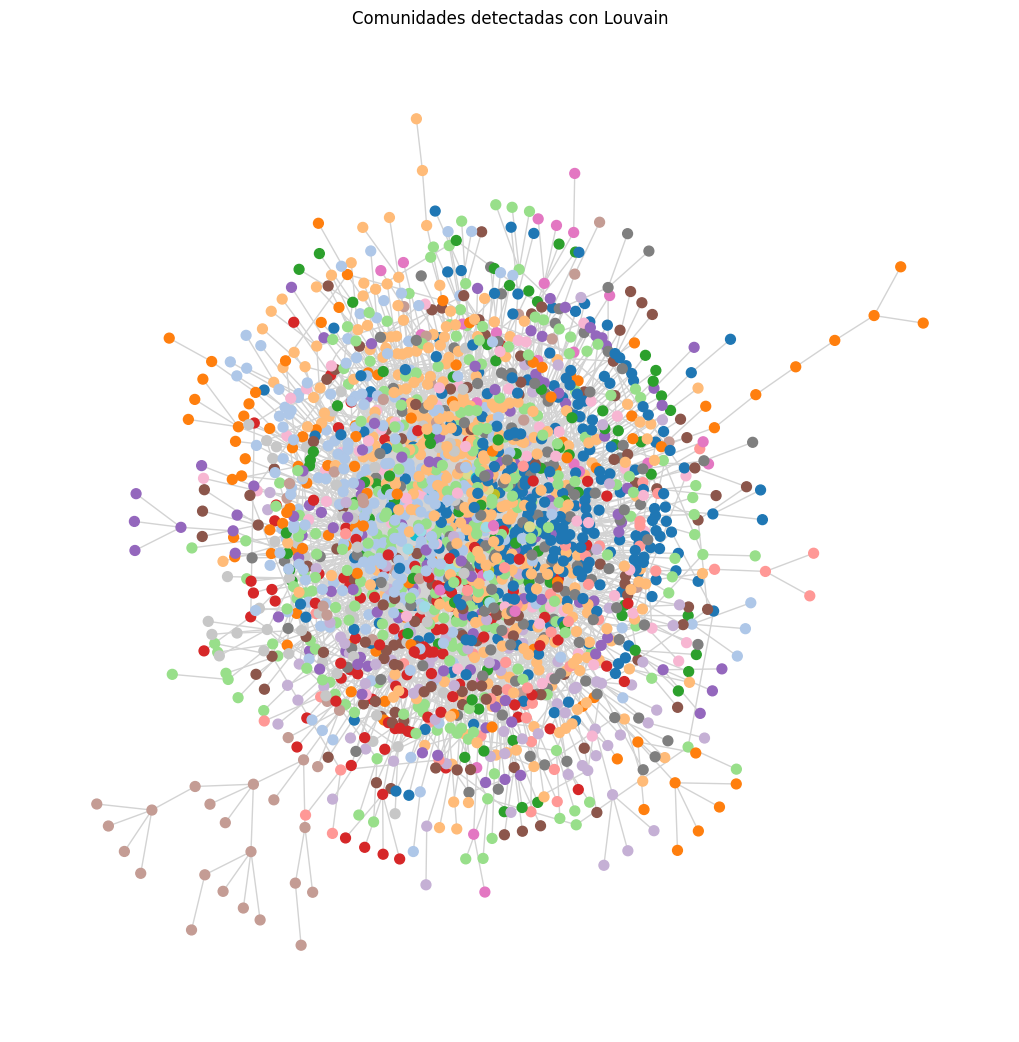

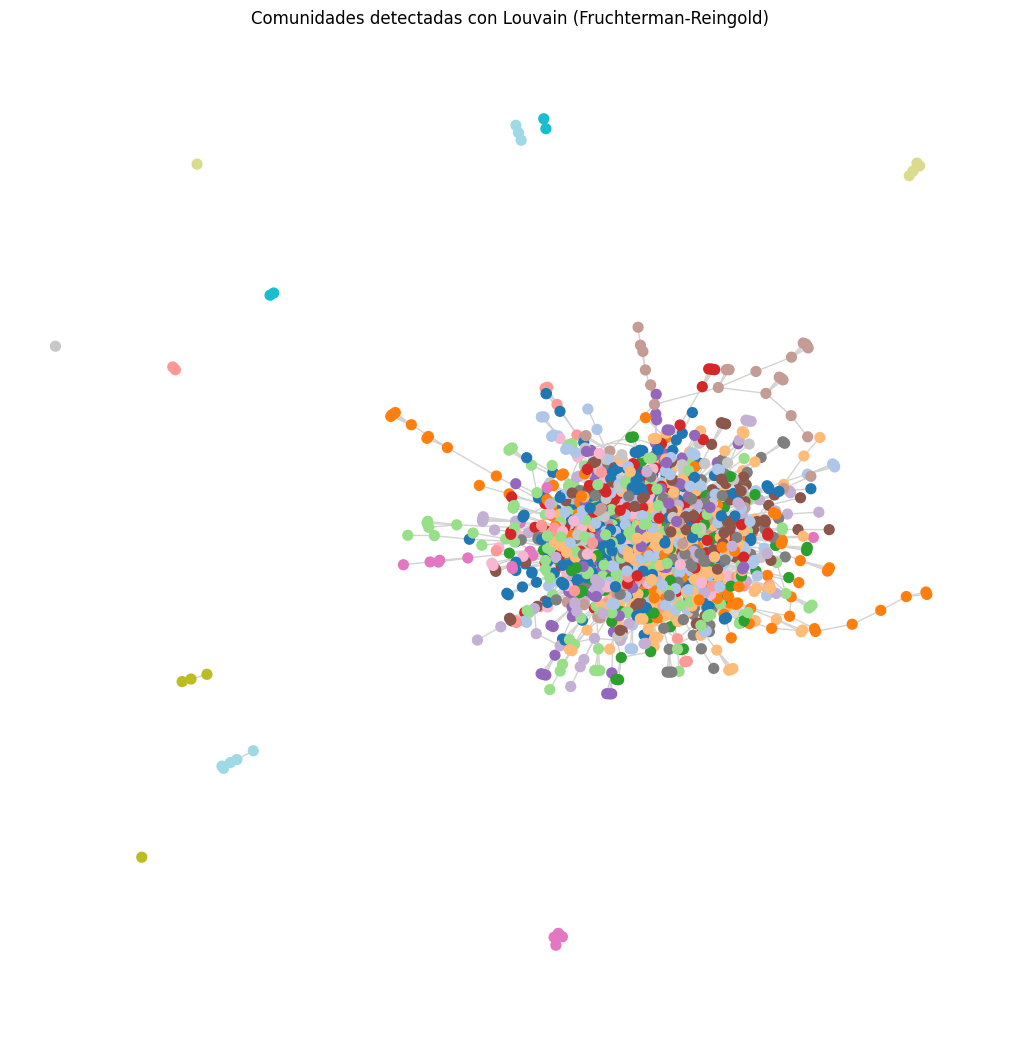

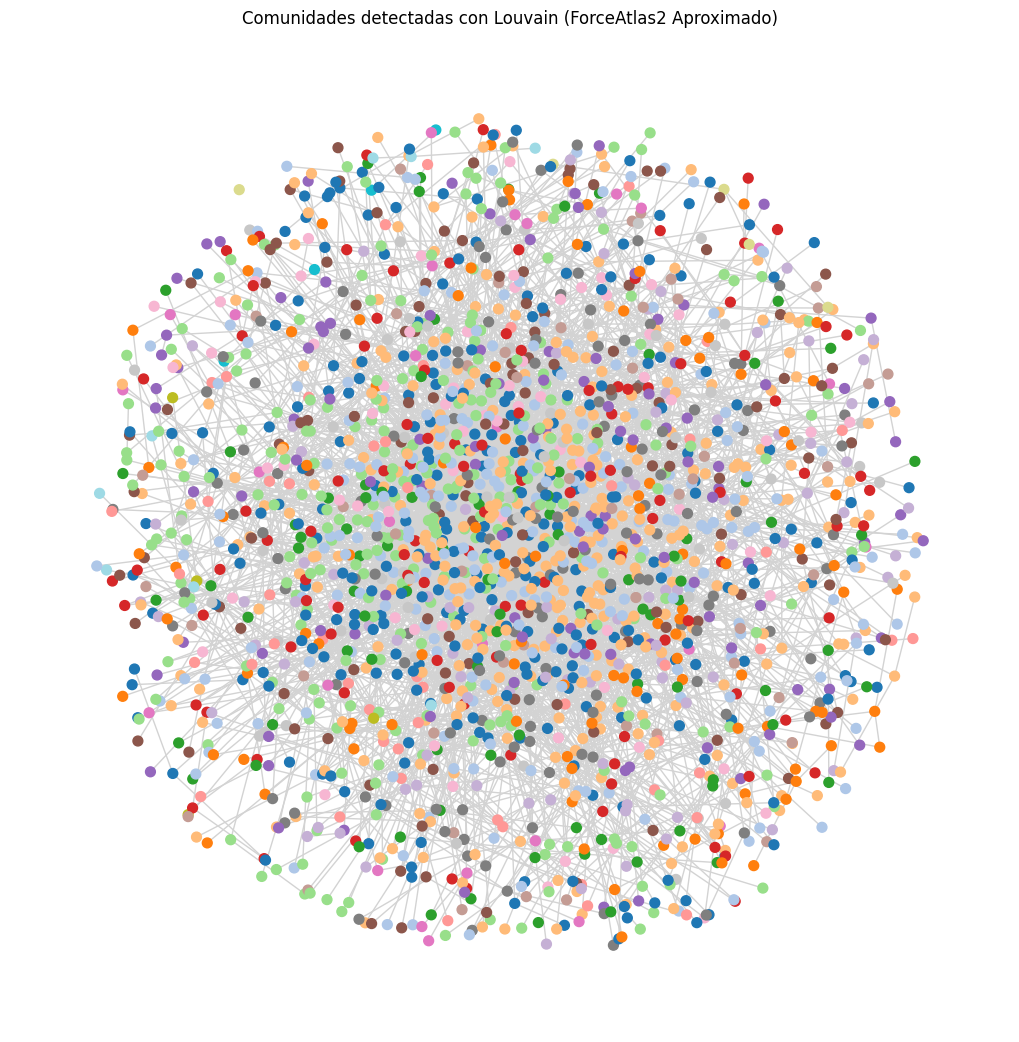

In [17]:
# Convertir a no dirigido
R = G.to_undirected()
# Aplicar algoritmo de Louvain
louvain_communities = community_louvain.best_partition(R)
# Asignar comunidades a los nodos
nx.set_node_attributes(G, louvain_communities, 'comunidad_louvain')
# Conteo de comunidades detectadas
comunidades_louvain = pd.Series(list(louvain_communities.values()))
print("Número de comunidades detectadas usando (Louvain):", comunidades_louvain.nunique())

# Graficar comunidades detectadas
fig = plt.figure(figsize=(10, 10))
pos = nx.kamada_kawai_layout(R)
nx.draw(R, pos=pos, node_size=50, 
        node_color=list(louvain_communities.values()), 
        cmap=plt.cm.tab20, edge_color='lightgray')
plt.title("Comunidades detectadas con Louvain")
plt.show()

# Graficar comunidades detectadas con Fruchterman-Reingold
fig = plt.figure(figsize=(10, 10))
pos_fr = nx.spring_layout(R, seed=42) 
nx.draw(R, pos=pos_fr, node_size=50, 
        node_color=list(louvain_communities.values()), 
        cmap=plt.cm.tab20, edge_color='lightgray')
plt.title("Comunidades detectadas con Louvain (Fruchterman-Reingold)")
plt.show()

# Graficar comunidades detectadas con ForceAtlas2 (Aproximación usando spring_layout)
fig = plt.figure(figsize=(10, 10))
pos_fa = nx.spring_layout(R, seed=42, k=0.15, iterations=50)
nx.draw(R, pos=pos_fa, node_size=50, 
        node_color=list(louvain_communities.values()), 
        cmap=plt.cm.tab20, edge_color='lightgray')
plt.title("Comunidades detectadas con Louvain (ForceAtlas2 Aproximado)")
plt.show()

Para validar la calidad de las comunidades en cada layout, utilizaremos dos métricas comunes en el análisis de grafos:

* Modularidad: Mide la densidad de conexiones dentro de las comunidades en comparación con una red aleatoria. Valores más altos indican comunidades más densamente conectadas.
* Coeficiente de Agrupamiento (Clustering Coefficient): Evalúa la densidad de triángulos en el grafo, lo cual indica cuán interconectados están los nodos en las comunidades.

In [ ]:
# Función para calcular la modularidad y el coeficiente de agrupamiento
def evaluar_calidad_comunidades(grafo, comunidades, nombre_layout):
    comunidades_lista = [[] for _ in range(max(comunidades.values())+1)]
    for nodo, comunidad in comunidades.items():
        comunidades_lista[comunidad].append(nodo)
    
    # Calcular Modularidad
    modularidad = community.modularity(grafo, comunidades_lista)
    print(f"\nModularidad ({nombre_layout}):", modularidad)
    
    # Calcular Coeficiente de Agrupamiento
    coef_agrupamiento = nx.average_clustering(grafo)
    print(f"Coeficiente de Agrupamiento ({nombre_layout}):", coef_agrupamiento)

# Evaluar calidad en Fruchterman-Reingold
evaluar_calidad_comunidades(R, louvain_communities, "Fruchterman-Reingold")

# Evaluar calidad en ForceAtlas2 Aproximado
evaluar_calidad_comunidades(R, louvain_communities, "ForceAtlas2 Aproximado")



Modularidad (Fruchterman-Reingold): 0.5837869624884381
Coeficiente de Agrupamiento (Fruchterman-Reingold): 0.00815338702050444

Modularidad (ForceAtlas2 Aproximado): 0.5837869624884381
Coeficiente de Agrupamiento (ForceAtlas2 Aproximado): 0.00815338702050444


Dado que los valores de modularidad y agrupamiento son idénticos, la elección del método se reduce a la visualización y el tamaño de la red, y segun la literatura Fruchterman-Reingold suele ser útil para grafos pequeños o medianos y tiende a separar bien las comunidades visualmente, optaremos por este metodo.Adicionalmente podemos concluir analizando la modularidad y coeficiente de agrupamiento que:
* La modularidad de aproximadamente 0.584 es bastante alta, lo que indica una buena división en comunidades. Valores superiores a 0.3 generalmente indican una estructura comunitaria relevante.
* El valor bajo (0.008) sugiere que, dentro de las comunidades, los nodos no están altamente interconectados entre sí, lo cual podría indicar comunidades más dispersas o menos cohesivas.

Ahora habiendo decisido el grafico del metodo de Fruchterman-Reingold, pasaremos a Hacer un analisis descriptivo

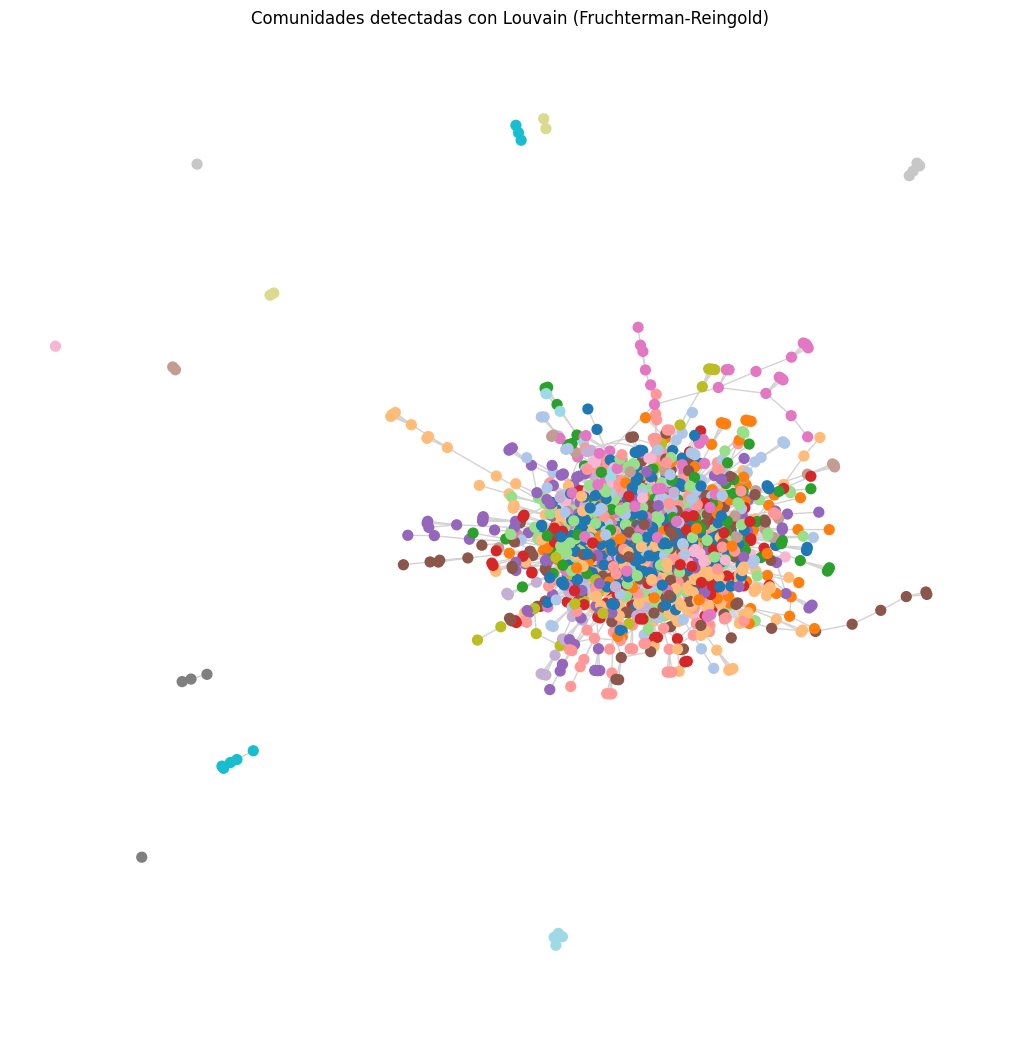

In [29]:
# Graficar comunidades detectadas con Louvain usando Fruchterman-Reingold
fig = plt.figure(figsize=(10, 10))
pos_fr = nx.spring_layout(R, seed=42) 
nx.draw(R, pos=pos_fr, node_size=50, 
        node_color=list(louvain_communities.values()), 
        cmap=plt.cm.tab20, edge_color='lightgray')
plt.title("Comunidades detectadas con Louvain (Fruchterman-Reingold)")
plt.show()


=== COMPARACIÓN DE ATRIBUTOS NUMÉRICOS ===


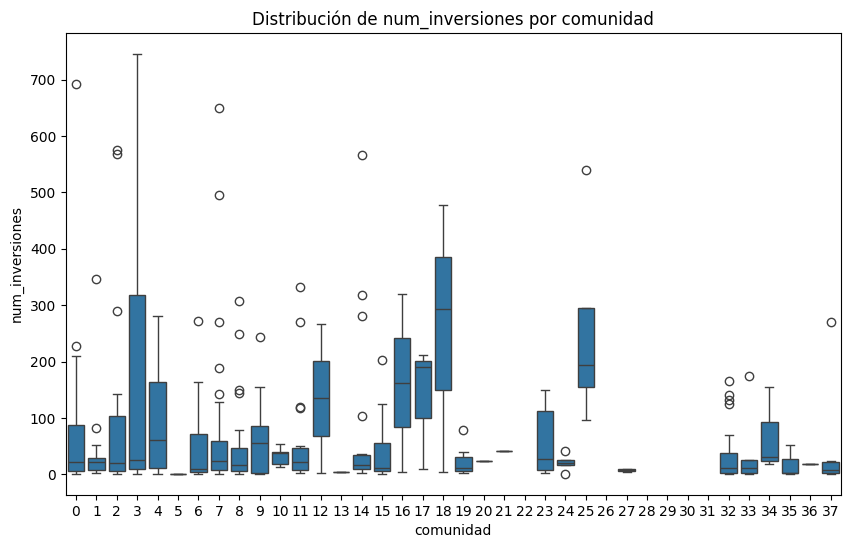

C:\Users\User\AppData\Local\Temp\ipykernel_6212\3734436744.py:26: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p = kruskal(*grupos)


Prueba de Kruskal-Wallis para num_inversiones: H = nan, p = nan
→ No hay diferencias significativas entre comunidades



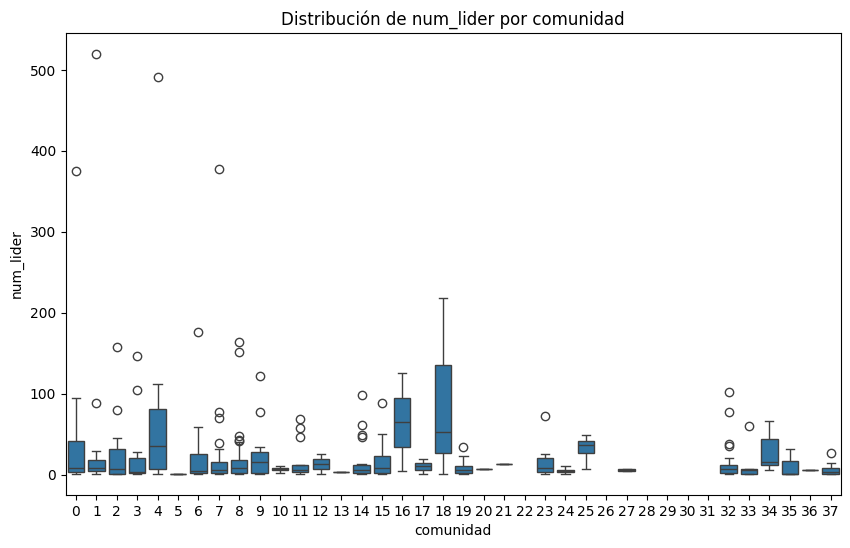

C:\Users\User\AppData\Local\Temp\ipykernel_6212\3734436744.py:26: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p = kruskal(*grupos)


Prueba de Kruskal-Wallis para num_lider: H = nan, p = nan
→ No hay diferencias significativas entre comunidades



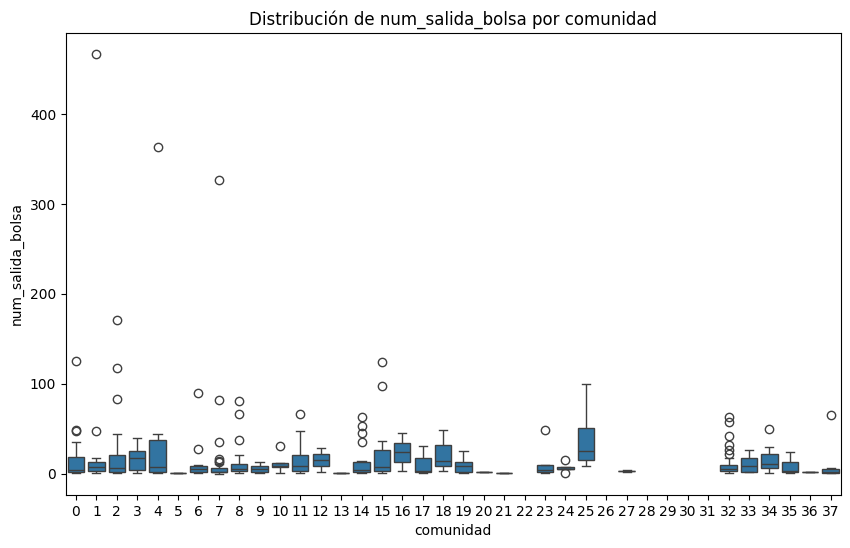

C:\Users\User\AppData\Local\Temp\ipykernel_6212\3734436744.py:26: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p = kruskal(*grupos)


Prueba de Kruskal-Wallis para num_salida_bolsa: H = nan, p = nan
→ No hay diferencias significativas entre comunidades



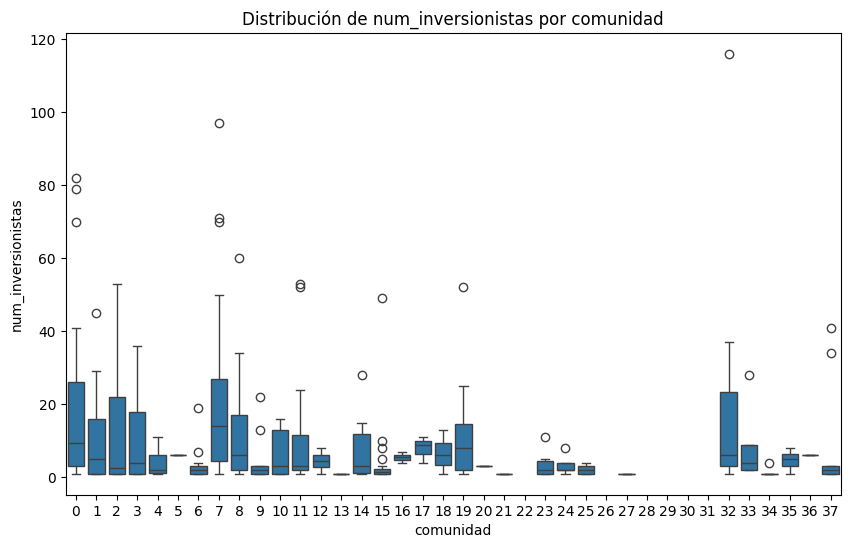

C:\Users\User\AppData\Local\Temp\ipykernel_6212\3734436744.py:26: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p = kruskal(*grupos)


Prueba de Kruskal-Wallis para num_inversionistas: H = nan, p = nan
→ No hay diferencias significativas entre comunidades



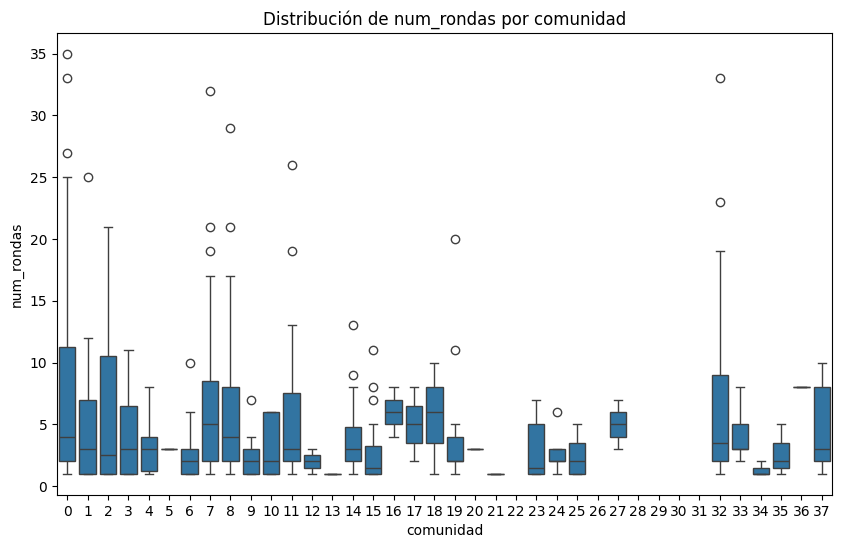

C:\Users\User\AppData\Local\Temp\ipykernel_6212\3734436744.py:26: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p = kruskal(*grupos)


Prueba de Kruskal-Wallis para num_rondas: H = nan, p = nan
→ No hay diferencias significativas entre comunidades



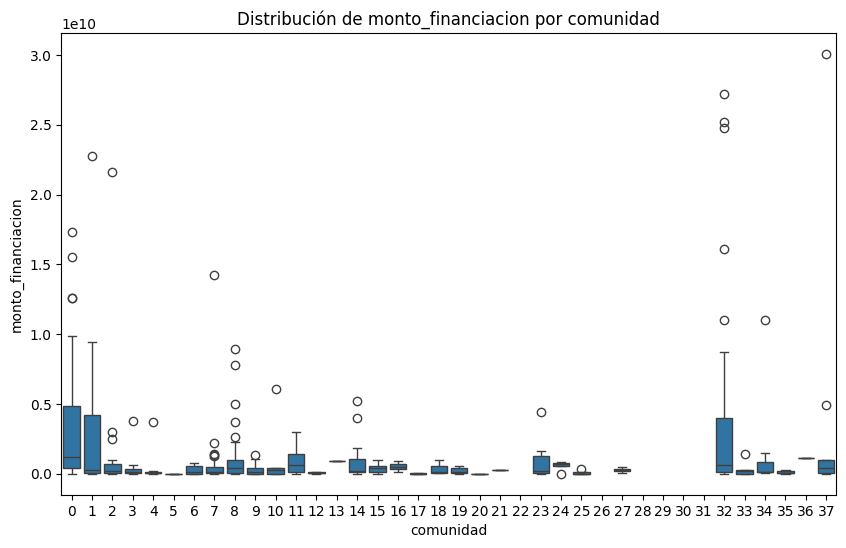

C:\Users\User\AppData\Local\Temp\ipykernel_6212\3734436744.py:26: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p = kruskal(*grupos)


Prueba de Kruskal-Wallis para monto_financiacion: H = nan, p = nan
→ No hay diferencias significativas entre comunidades


=== COMPARACIÓN DE ATRIBUTOS CATEGÓRICOS ===


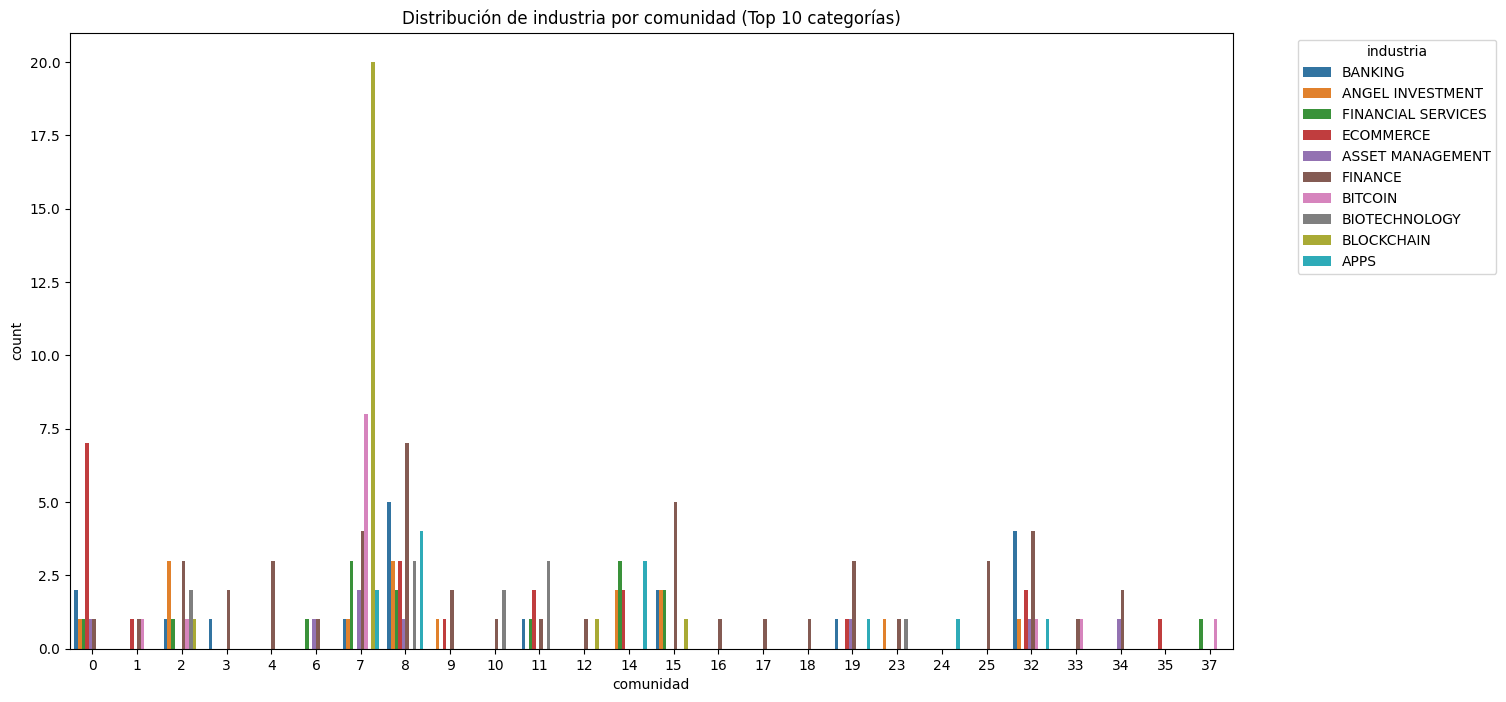

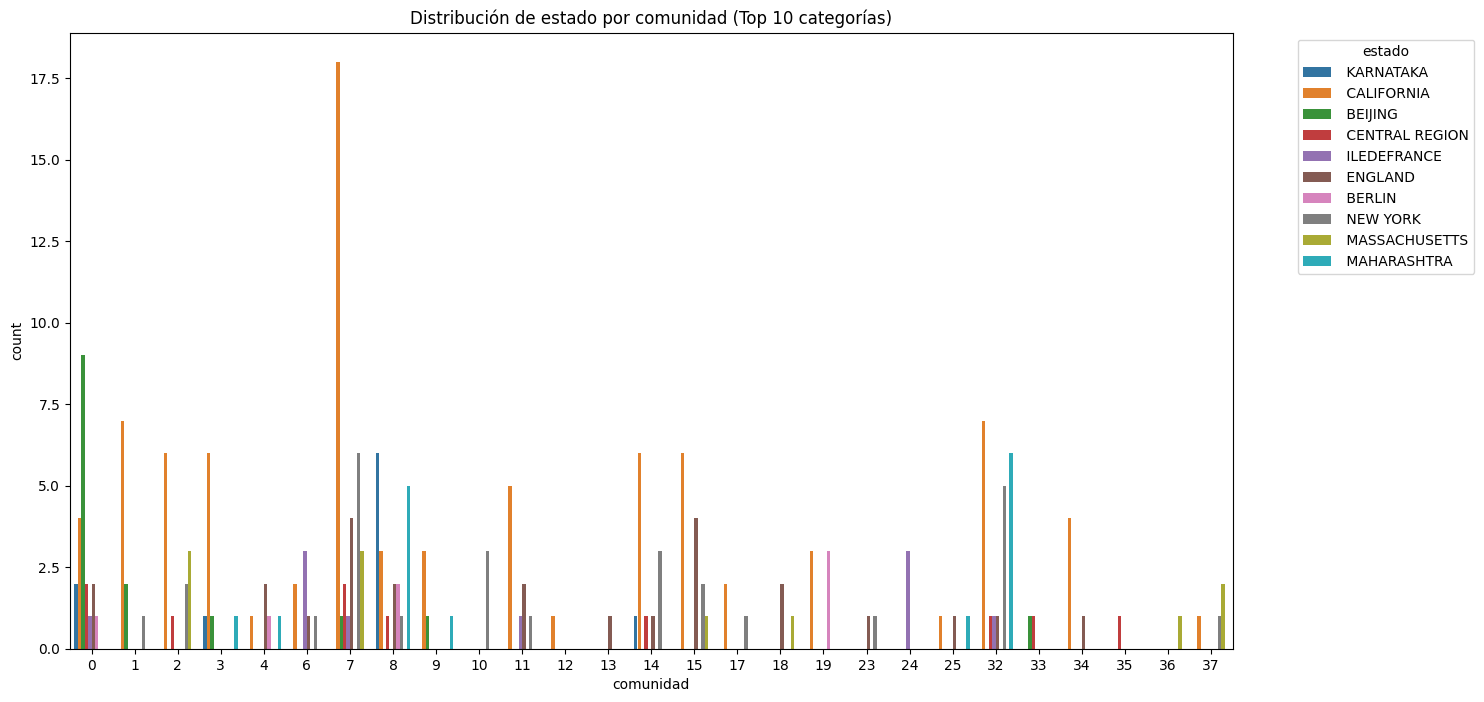


=== ANÁLISIS DE HOMOFILIA ===
Homofilia para industria: 0.6303
Homofilia para estado: 0.6346


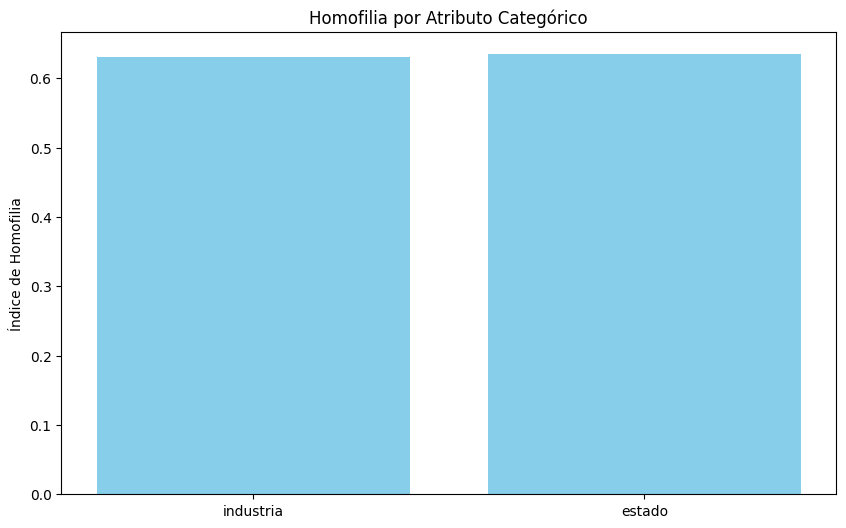

In [ ]:
# ¿Que puedo decir de mis comunidades dectectadas?
# --------------------
# Análisis descriptivo
# --------------------
# Datos de análisis
atributos_numericos = ['num_inversiones', 'num_lider', 'num_salida_bolsa', 'num_inversionistas', 'num_rondas', 'monto_financiacion']
atributos_categoricos = ['industria', 'estado']

data_analisis = pd.DataFrame([{**G.nodes[n], 'comunidad': louvain_communities[n]} for n in G.nodes])

# ---------------------------------------
# Comparación de atributos dentro y entre comunidades
# ---------------------------------------

## Atributos numéricos
print("\n=== COMPARACIÓN DE ATRIBUTOS NUMÉRICOS ===")
for atributo in atributos_numericos:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='comunidad', y=atributo, data=data_analisis)
    plt.title(f'Distribución de {atributo} por comunidad')
    plt.show()

    # Prueba estadística de Kruskal-Wallis para comparar entre comunidades
    grupos = [grupo[atributo].dropna().values for nombre, grupo in data_analisis.groupby('comunidad')]
    stat, p = kruskal(*grupos)
    print(f"Prueba de Kruskal-Wallis para {atributo}: H = {stat:.4f}, p = {p:.4f}")
    if p < 0.05:
        print("→ Diferencias significativas entre comunidades\n")
    else:
        print("→ No hay diferencias significativas entre comunidades\n")

## Atributos categóricos (agrupados por frecuencia)
print("\n=== COMPARACIÓN DE ATRIBUTOS CATEGÓRICOS ===")
for atributo in atributos_categoricos:
    top_categorias = data_analisis[atributo].value_counts().head(10).index  # Top 10 categorías más frecuentes
    data_filtrada = data_analisis[data_analisis[atributo].isin(top_categorias)]

    plt.figure(figsize=(15, 8))
    sns.countplot(x='comunidad', hue=atributo, data=data_filtrada)
    plt.title(f'Distribución de {atributo} por comunidad (Top 10 categorías)')
    plt.legend(title=atributo, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# ---------------------------------------
# Análisis de Homofilia
# ---------------------------------------

print("\n=== ANÁLISIS DE HOMOFILIA ===")

# Función para calcular índice de homofilia
def indice_homofilia(G, atributo):
    sim = 0
    total = 0
    for u, v in G.edges():
        if G.nodes[u].get(atributo) == G.nodes[v].get(atributo):
            sim += 1
        total += 1
    return sim / total if total > 0 else 0

# Calcular y mostrar homofilia para cada atributo categórico
homofilia_resultados = {}
for atributo in atributos_categoricos:
    homofilia = indice_homofilia(G, atributo)
    homofilia_resultados[atributo] = homofilia
    print(f"Homofilia para {atributo}: {homofilia:.4f}")

# Visualización de Homofilia
plt.figure(figsize=(10, 6))
plt.bar(homofilia_resultados.keys(), homofilia_resultados.values(), color='skyblue')
plt.ylabel('Índice de Homofilia')
plt.title('Homofilia por Atributo Categórico')
plt.show()




*Interpretacion del analisis anterior:*     PIPE AYUDAME DESDE ACA PORFI

##### 2.2 Método de Overlapping Communities utilizando k_clique_communities.